In [1]:
###################################################################################################
#
# Copyright (C) 2024 Analog Devices, Inc. All Rights Reserved.
# This software is proprietary and confidential to Analog Devices, Inc. and its licensors.
#
###################################################################################################
"""
Evaluate tarined and quantized checkpoint for Voyager4 Dataset

"""
import os
import sys

import numpy as np
import torch

import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'models'))

from datasets import motordatavoyager4

ai85net_autoencoder = __import__("ai85net-autoencoder")

import parse_qat_yaml
import ai8x

from torch.utils import data

from distiller import apputils

import seaborn as sns

from statistics import mean
from utils import autoencoder_eval_utils

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
simulate = True

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

args = Args(act_mode_8bit=simulate)

ai8x.set_device(device=85, simulate=simulate, round_avg=True)

Configuring device: MAX78000, simulate=True.


In [3]:
# Generate Dataset For Evaluation
train_set, test_set = \
    motordatavoyager4.motordatavoyager4_get_datasets_for_eval_with_anomaly_label((data_path, args),
                                                                                     load_train=True, load_test=True)


Pickle files are already generated ...

Train dataset length: 449


Pickle files are already generated ...

Test dataset length: 537



In [6]:


selected_idx = 13

sample_item = test_set[selected_idx]
sample_input = sample_item[0].cpu().detach().numpy()

sample_label = sample_item[1]


print(sample_input.shape)
print(sample_input.dtype)
print([sample_input.min(), sample_input.max()])

print(sample_label.dtype)
print(sample_label)

(256, 3)
float32
[-128.0, 127.0]
int64
[0]


In [4]:
batch_size = 32
train_dataloader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

### 1. Load Trained AE

In [5]:
model = ai85net_autoencoder.ai85autoencoder()
_ = autoencoder_eval_utils.calc_model_size(model)

Batchnorm setting in model =  True

Number of Model Weights: 136640
Number of Model Bias: 544



In [6]:
# Change this checkpoint file path with your own trained one
checkpoint_path = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()),
                                               os.pardir,
                                               'ai8x-synthesis',
                                               'trained',
                                               'ai85-autoencoder-motordatavoyager4-qat-q.pth.tar'))

In [7]:
qat_yaml_file_used_in_training = os.path.join(os.path.dirname(os.getcwd()),
                                              'policies',
                                              'qat_policy_autoencoder.yaml')

qat_policy = parse_qat_yaml.parse(qat_yaml_file_used_in_training)

ai8x.set_device(85, simulate, False)

# Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
ai8x.fuse_bn_layers(model)

model = apputils.load_lean_checkpoint(model, checkpoint_path, model_device=device)

# Switch model from unquantized to quantized for QAT
ai8x.initiate_qat(model, qat_policy)

ai8x.update_model(model)

model = model.to(device)

Configuring device: MAX78000, simulate=True.


### Visualizing whether trained model has good separation the latent space

In [8]:
train_base_tuple = autoencoder_eval_utils.extract_reconstructions_losses(model, train_dataloader, device)
train_base_reconstructions, train_base_losses, train_base_inputs, train_base_labels = train_base_tuple
    
print(len(train_base_losses))

449


In [9]:
test_base_tuple = autoencoder_eval_utils.extract_reconstructions_losses(model, test_dataloader, device)
test_base_reconstructions, test_base_losses, test_base_inputs, test_base_labels = \
    test_base_tuple
    
print(len(test_base_losses))

537


In [10]:
normal_test_sample_idxs = [test_item_idx for test_item_idx, test_item in enumerate(test_set) if test_item[1] == 0]
normal_test_samples = torch.utils.data.Subset(test_set, normal_test_sample_idxs)
normal_test_samples_loader = torch.utils.data.DataLoader(normal_test_samples, batch_size=batch_size)
print(len(normal_test_sample_idxs))

115


In [11]:
normal_test_output = autoencoder_eval_utils.extract_reconstructions_losses(model, normal_test_samples_loader, device)
    
test_normal_reconstructions, test_normal_losses, test_normal_inputs, test_normal_labels = normal_test_output

print(len(test_normal_losses))

115


In [12]:
anormal_test_sample_idxs = [test_item_idx for test_item_idx, test_item in enumerate(test_set) if test_item[1] == 1]
print(len(anormal_test_sample_idxs))

anormal_test_samples = torch.utils.data.Subset(test_set, anormal_test_sample_idxs)
anormal_test_samples_loader = torch.utils.data.DataLoader(anormal_test_samples, batch_size=batch_size)

422


In [13]:
anormal_output = autoencoder_eval_utils.extract_reconstructions_losses(model, anormal_test_samples_loader, device)
    
test_anormal_reconstructions, test_anormal_losses, test_anormal_inputs, test_anormal_labels = anormal_output
print(len(test_anormal_losses))

422


### 2. Determine Reconst. Err. Threshold: 
#### Using 100% percentile of Training Samples

In [14]:
percentiles = [90, 95, 99, 100]
thresholds = np.percentile(train_base_losses, percentiles)

for idx, threshold in enumerate(thresholds):
    print(f'{percentiles[idx]}% percentile threshold: {threshold:.4f}')

90% percentile threshold: 8.1201
95% percentile threshold: 8.6107
99% percentile threshold: 9.3869
100% percentile threshold: 10.1107


In [15]:
# Calculating performance metrics with respect to changing thresholds
F1s, BalancedAccuracies, FPRs, Recalls = autoencoder_eval_utils.sweep_performance_metrics(thresholds, train_base_tuple, test_base_tuple)

F1:  0.9859, BalancedAccuracy:  0.9510, FPRate:  0.0957, Precision:  0.9745, TPRate (Recall):  0.9976, Accuracy:  0.9777, TRAIN-SET Accuracy:  0.8998
F1:  0.9953, BalancedAccuracy:  0.9858, FPRate:  0.0261, Precision:  0.9929, TPRate (Recall):  0.9976, Accuracy:  0.9926, TRAIN-SET Accuracy:  0.9488
F1:  0.9952, BalancedAccuracy:  0.9921, FPRate:  0.0087, Precision:  0.9976, TPRate (Recall):  0.9929, Accuracy:  0.9926, TRAIN-SET Accuracy:  0.9889
F1:  0.9964, BalancedAccuracy:  0.9964, FPRate:  0.0000, Precision:  1.0000, TPRate (Recall):  0.9929, Accuracy:  0.9944, TRAIN-SET Accuracy:  0.9978


Text(0.5, 0, 'Reconstruction Loss (RL)')

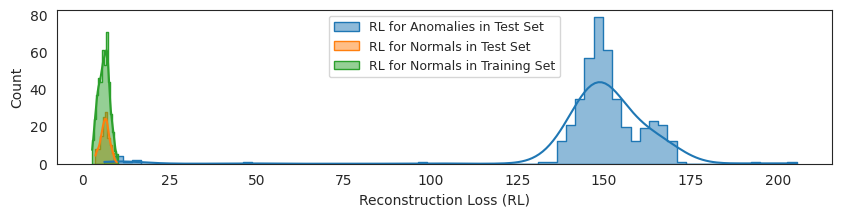

In [16]:
%matplotlib inline

plt.figure(figsize=(10, 2))

sns.histplot(test_anormal_losses, element="step", label='RL for Anomalies in Test Set', kde=True)
sns.histplot(test_normal_losses, element="step", label='RL for Normals in Test Set', kde=True)
sns.histplot(train_base_losses, element="step", label='RL for Normals in Training Set', kde=True)

plt.legend(prop={'size': 9}, loc='best')
plt.xlabel('Reconstruction Loss (RL)')


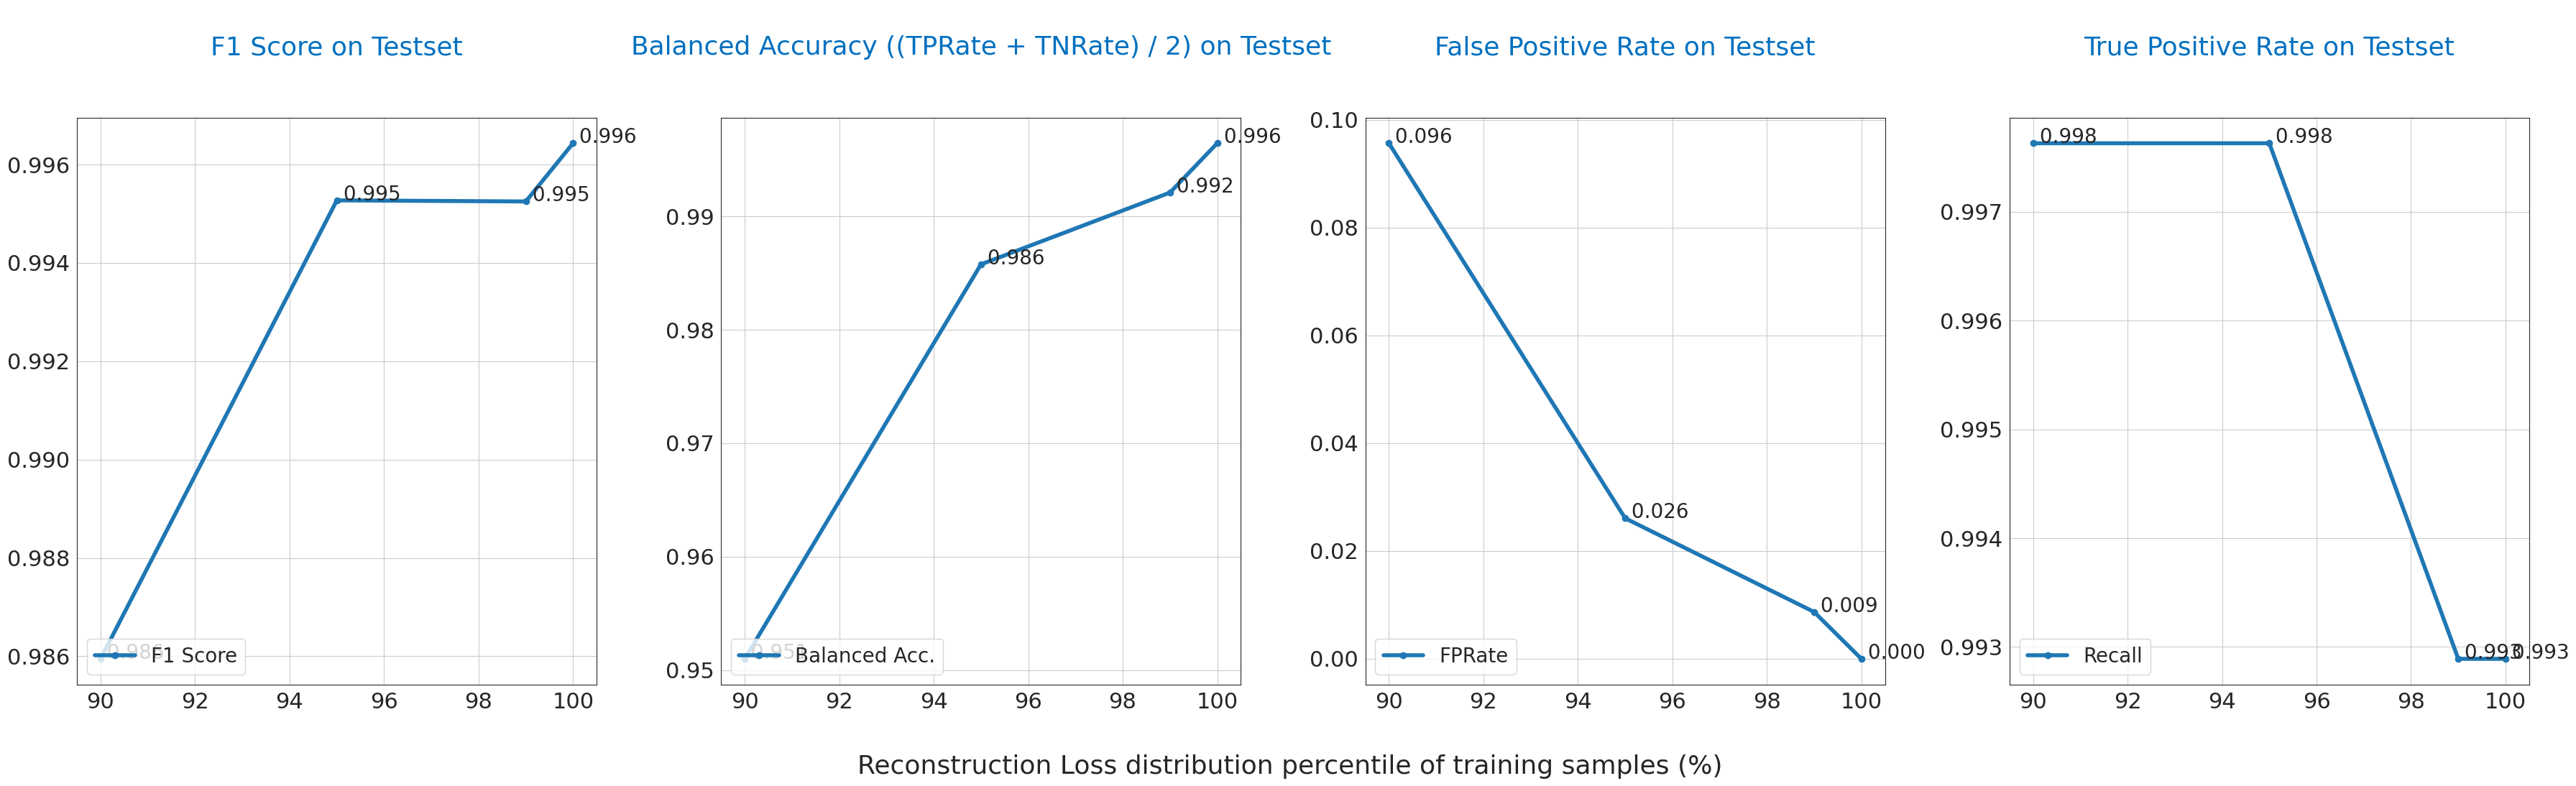

In [17]:
autoencoder_eval_utils.plot_all_metrics(F1s=F1s, BalancedAccuracies=BalancedAccuracies, FPRs=FPRs, Recalls=Recalls, percentiles=percentiles)